# Test Notebook
Using this notebook to test the library functions as it is being built.

In [1]:
# --- Standards
import numpy as np
import matplotlib.pyplot as plt
# --- relative
#import sys
#sys.path.insert(0, '../instrSimTools/')
from filters import *
from waveforms import *
from circuit import *


# LEC Cooling Section
The cooling section in the LEC will have 3 electron bunches for every proton bunch. The electron bunches are seperated at 197 MHz and Gaussian with $\sigma$ = 5 cm. The proton bunches are seperated at 24.6 MHz and have a flattened Cosine-squared shape as a result of the 2nd harmonic (49.2 MHz) cavity.

In [8]:
# --- Constants
pRF1 = 24.6e6   # RF frequency [Hz]
pRF2 = 49.3e6   # 2nd Harmonic RF frequency [Hz]
eRF1 = 197.1e6  # electron bunch seperation RF frequency [Hz]
e_sigma = 0.05 / const.c  # electron rms bunch length [s]
num_bunches = 1

time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 1000)  # time array for 1 RF cycle
e_time_ary = np.linspace(-1*(num_bunches*0.5)/eRF1, num_bunches*0.5/eRF1, 1000)
abs( time_ary[1] - time_ary[0] )

4.069109760166522e-11

In [9]:
# --- Make Proton Signal
proton_sig_1 = cosine_square_pulse(time_ary, (1/pRF1))
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)

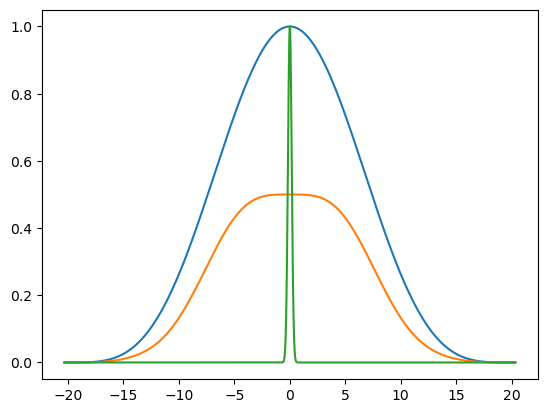

In [ ]:
plt.figure()
plt.plot(time_ary*1e9, proton_sig_1)
plt.plot(time_ary*1e9, proton_sig_2)
plt.plot(time_ary*1e9, electron_sig)
plt.show()

In [ ]:
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
# abs( e_pulse_train[0][1] - e_pulse_train[0][0] )
shift_t = e_pulse_train[0].shape[0]//2
test_pulseTrain_time_ary = e_pulse_train[0] - e_pulse_train[0][shift_t-1]

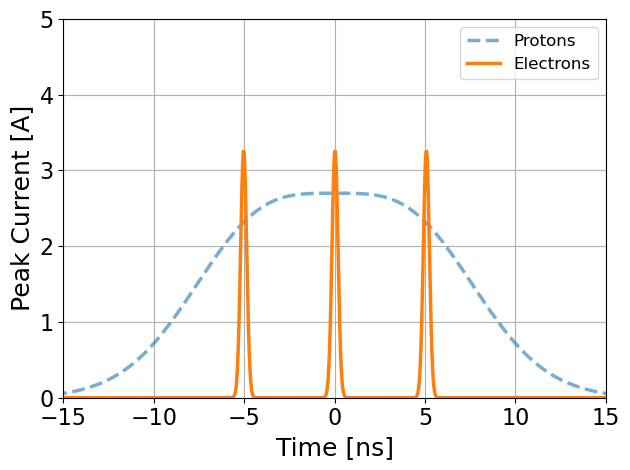

In [ ]:
plt.figure()
plt.plot( time_ary*1e9, 5.4*proton_sig_2, label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
plt.plot( test_pulseTrain_time_ary*1e9, 3.25*e_pulse_train[1], label='Electrons', linewidth=2.5)

# --- axis settings 
plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [-15, 15] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()

plt.show()

Good. Now make a pulse train of proton bunchese and electron macrobunches

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 3)

In [ ]:
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

#### BUG - Timing not right
Bug... the pulse is coming in much smaller than the period, so I need to add padding to make up the difference

In [ ]:
# --- Debug timing issue with pulse train
# --------------------------------------------------------------

Fs = 1 / (test_pulseTrain_time_ary[1] - test_pulseTrain_time_ary[0])
pulse_period = 1 / pRF1
print("electron_sig size: {}".format(electron_sig.size))

temp = e_pulse_train[1][test_pulseTrain_time_ary > -pulse_period / 2]
print("0.5 * Pulse period: |{}|".format(pulse_period/2))
temp_time_ary = test_pulseTrain_time_ary[test_pulseTrain_time_ary > -pulse_period / 2]
print("Upper - Cut --> temp size: {}".format(temp.size))

temp = temp[temp_time_ary < pulse_period / 2]
print("Lower - Cut --> temp size: {}".format(temp.size))

pulse_ary = np.copy( temp )
print("pulse ary size: {}".format(pulse_ary.size))

In [ ]:
temp_time_ary[-1]-temp_time_ary[0]

In [ ]:
# Check if pulse_time is smaller than pulse_period
if (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0]) < pulse_period:
    # Calculate the number of samples to zero-pad
    num_zeros = int((pulse_period - (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0])) * Fs)
    
    # Zero-pad the pulse
    temp_pulse = np.pad(e_pulse_train[1], num_zeros//2, mode='constant')
    
print("temp_pulse size: {}".format(temp_pulse.size))

In [ ]:
# --- create new timing array... 
new_time_ary_linspace = np.linspace( -0.5*pulse_period, 0.5*pulse_period, temp_pulse.size )
print("new_time_ary_linspace size: {}".format(new_time_ary_linspace.size))
new_time_ary_arange = np.arange( -0.5*pulse_period, 0.5*pulse_period, 1/Fs )
print("new_time_ary_arange size: {}".format(new_time_ary_arange.size))


In [ ]:
plt.figure()
plt.plot( test_pulseTrain_time_ary*1e9, e_pulse_train[1] )
plt.plot( new_time_ary_arange*1e9, temp_pulse )
plt.show()

Good... fixed
____
#### Back to testing

In [ ]:
# --- Re - Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

Excellent! Now to make it look pretty with fancy plotting. <br><br>
Note: Pulse trains have a full period before and after. Consider making this optional. 

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5)
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5)

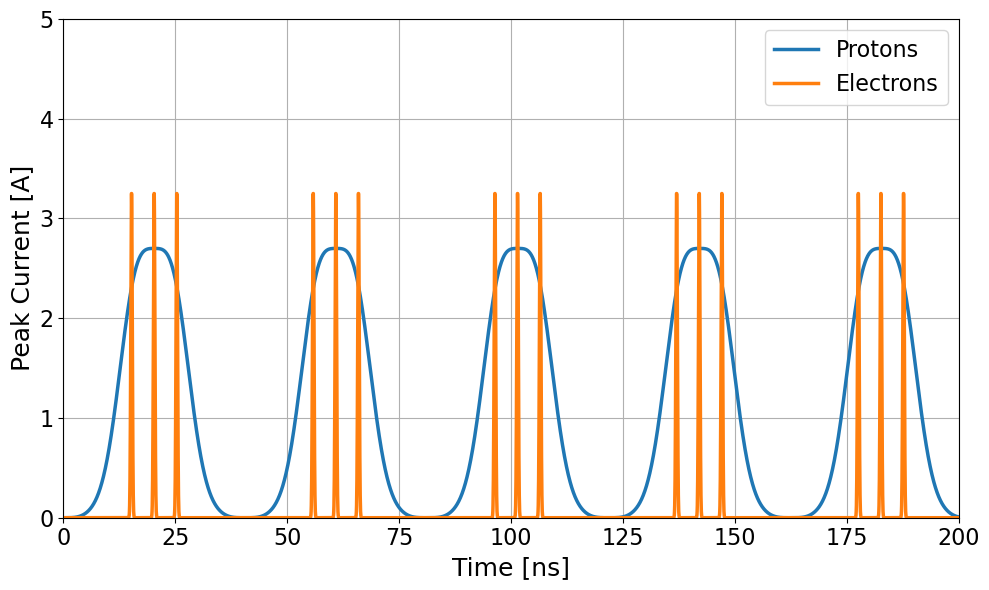

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(p_pulse_train[0] * 1e9, 5.4*p_pulse_train[1], label='Protons',linewidth=2.5)
plt.plot(e_macro_train[0] * 1e9, 3.25*e_macro_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()
plt.show()

In [ ]:
idx = np.argmax( p_pulse_train[1] )
peak_1 = p_pulse_train[0][idx]
peak_2 = p_pulse_train[0][idx+np.argmax( p_pulse_train[1][idx+5:] )]
# peak_2 = np.argmax( p_pulse_train[1][idx+5:] )
print(f"Peak 1: {peak_1*1e9:.2f} ns")
print(f"Peak 2: {peak_2*1e9:.2f} ns")

In [ ]:
# --- Make LEReC Electron Signal
lerec_sigma = 0.02 / const.c  # electron rms bunch length [s]
LEReC_time_ary = np.linspace(-1*(1*0.5)/(9.1e6), 1*0.5/(9.1e6), 1000)  # time array for 1 RF cycle
LEReC_sig, sigma_conf = gaussian_pulse( LEReC_time_ary, sigma=lerec_sigma)
# --- Make LEReC Electron Macro-bunch
LEReC_macro_bunch = create_pulse_train(704e6, LEReC_sig, LEReC_time_ary, 30, pad_train=(2,2))
# --- Make LEReC Pulse Train
LEReC_pulse_train = create_pulse_train((9.1e6), LEReC_macro_bunch[1], LEReC_macro_bunch[0], 5)

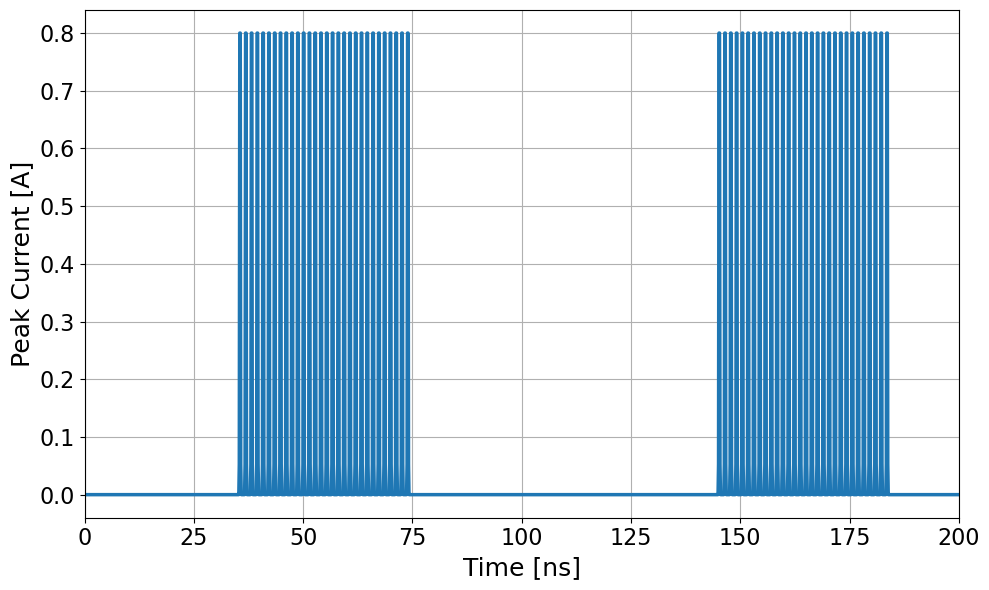

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(LEReC_pulse_train[0] * 1e9, 0.8*LEReC_pulse_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
# plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
# plt.ylim( [0.0, 6.0] )
plt.tight_layout()
plt.show()

### Make Spectrum Plots

In [ ]:
num_bunches = 10
time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 20000)  # time array for 1 RF cycle
pFs = 1/(time_ary[1] - time_ary[0])

NameError: name 'np' is not defined

In [ ]:
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Proton Spectrum
PS2_freq, PS2_spec = get_spectrum( proton_sig_2, pFs )

In [ ]:
# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
emb_Fs = 1/(e_pulse_train[0][1] - e_pulse_train[0][0])
# --- Electron Spectrum
e_freq, e_spec = get_spectrum( electron_sig, pFs )
emb_freq, emb_spec = get_spectrum( e_pulse_train[1], emb_Fs )

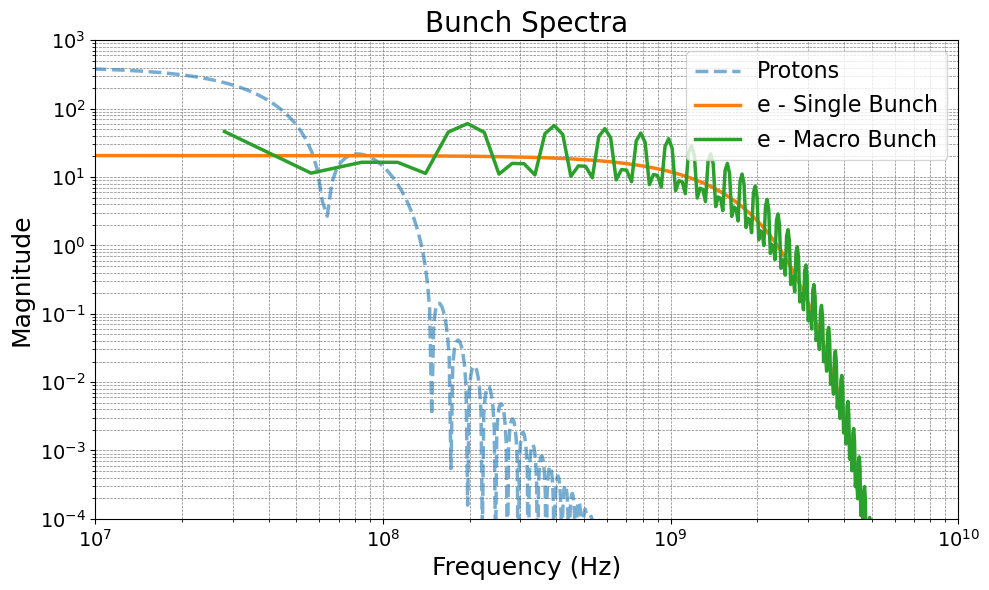

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(PS2_freq[PS2_freq>0], np.abs(PS2_spec[PS2_freq>0]), label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
ax.plot(e_freq[e_freq>0], np.abs(e_spec[e_freq>0]), label='e - Single Bunch',linewidth=2.5)
ax.plot(emb_freq[emb_freq>0], np.abs(emb_spec[emb_freq>0]), label='e - Macro Bunch',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5, pad_train=(2,2))
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5, pad_train=(2,2))

In [ ]:
# --- Bunch Train Spectra
pt_FS = 1 / (p_pulse_train[0][1]-p_pulse_train[0][0])
et_FS = 1 / (e_macro_train[0][1]-e_macro_train[0][0])

pt_freq, pt_spec = get_spectrum( p_pulse_train[1], pt_FS )
et_freq, et_spec = get_spectrum( e_macro_train[1], et_FS )

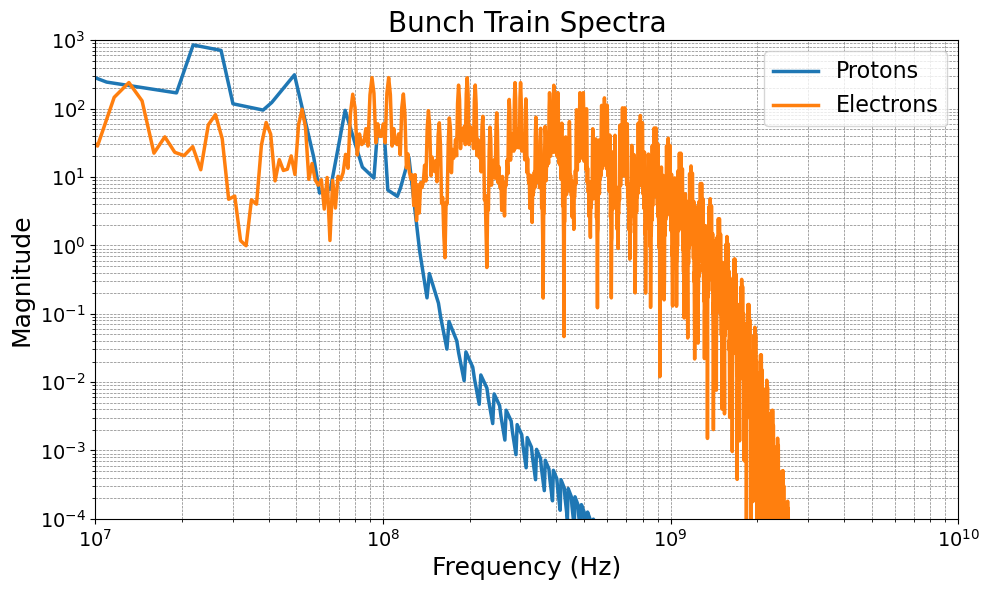

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pt_freq[pt_spec>0], np.abs(pt_spec[pt_spec>0]), label='Protons',linewidth=2.5)
ax.plot(et_freq[et_freq>0], np.abs(et_spec[et_freq>0]), label='Electrons',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Train Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Wall Current Monitor Simulation
The goal is to create an RLC simulation of a wall current monitor

In [19]:
# --- RHIC WCM Circuit
# --- --- Analytical Model
wcm_ntwk = simple_wcm_circuit( Cb=65.17e-12, Cc=15e-12, Cp=0.5e-12*83, Ls=2e-9/83, Lby=189.79e-6, Rp=100/83 )

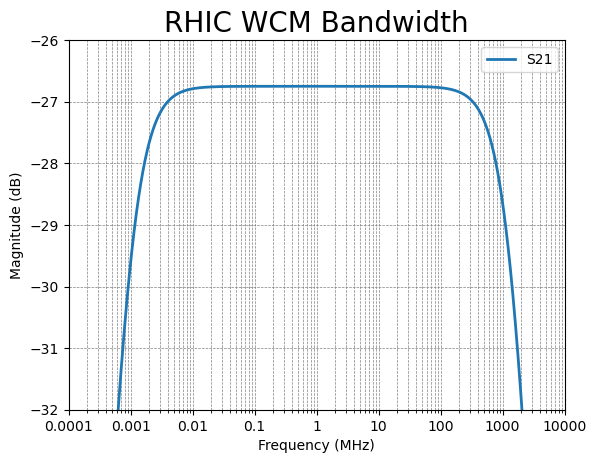

In [20]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.ylim([-32, -26])
plt.title("RHIC WCM Bandwidth", fontsize=20)
plt.show()

In [21]:
BW, Flow, Fhigh, pass_mag = measure_3db_bandwidth( wcm_ntwk )
print( "{} MHz".format(BW*1e-6) )
print( "{} Hz".format(Flow) )
print( "{} MHz".format(Fhigh*1e-6) )
print( "{} dB".format(pass_mag) )

1342.7639948200185 MHz
966.3178455932789 Hz
1342.764961137864 MHz
-26.74918505736073 dB


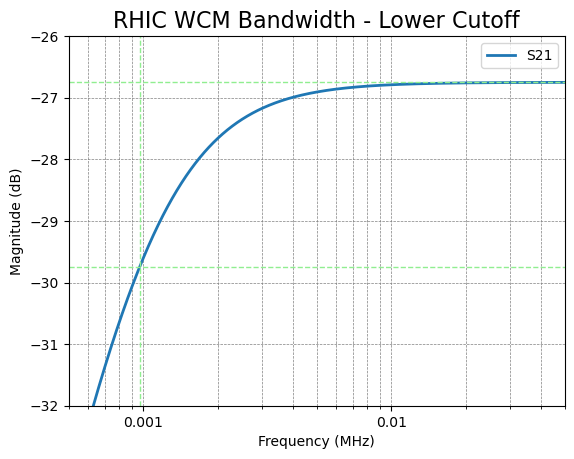

In [22]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
# Add dashed horizontal line at the passband magnitude
plt.axhline(y=pass_mag, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed horizontal line at the passband magnitude - 3dB
plt.axhline(y=pass_mag-3, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed vertical line at 3dB mark
plt.axvline(x=Flow, color='lightgreen', linestyle='--', linewidth=1)
plt.ylim([-32, -26])
plt.xlim([0.0005e6, 0.05e6])
plt.title("RHIC WCM Bandwidth - Lower Cutoff", fontsize=16)
plt.show()

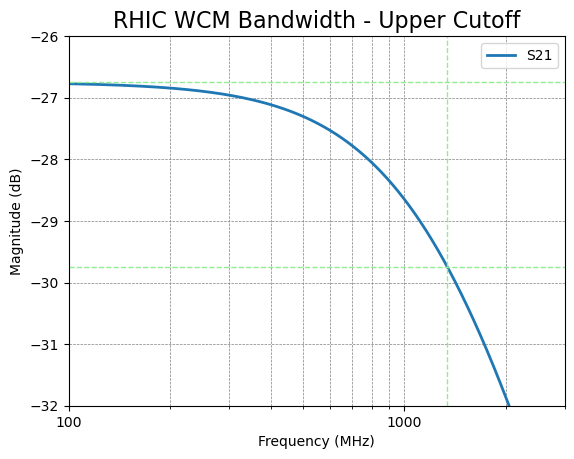

In [23]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
# Add dashed horizontal line at the passband magnitude
plt.axhline(y=pass_mag, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed horizontal line at the passband magnitude - 3dB
plt.axhline(y=pass_mag-3, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed vertical line at 3dB mark
plt.axvline(x=Fhigh, color='lightgreen', linestyle='--', linewidth=1)
plt.ylim([-32, -26])
plt.xlim([100e6,3000e6])
plt.title("RHIC WCM Bandwidth - Upper Cutoff", fontsize=16)
plt.show()

## Test Vector Fitting
Export the RLC model using Vector Fitting to test out how to do it.

C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\177140861.py:2: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit( )


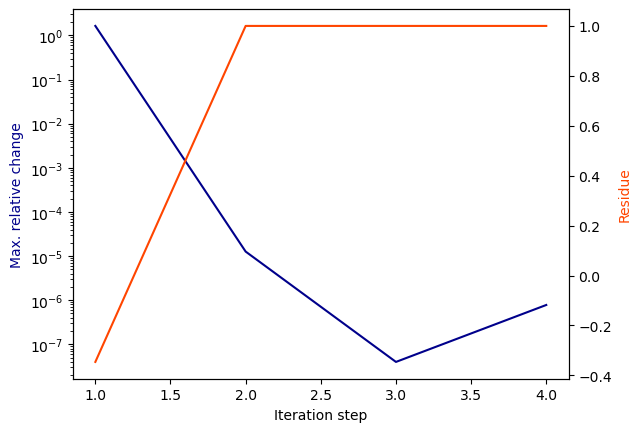

In [24]:
vf = rf.VectorFitting( wcm_ntwk )
vf.vector_fit( )
vf.plot_convergence()
plt.show()

In [25]:
vf.passivity_enforce()
vf.get_rms_error()

C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: UserWarning: Passivity enforcement: The dc point in the model is not passive. Cannot preserve the dc point during passivity enforcement. 
  vf.passivity_enforce()
C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: UserWarning: Passivity enforcement: The passivity violations of this model are unbounded. Passivity enforcement might still work, but consider re-fitting with a lower number of poles and/or without the constants (`fit_constant=False`) if the results are not satisfactory.
  vf.passivity_enforce()
C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: RuntimeWarning: Passivity enforcement was not successful.
Model is still non-passive in these frequency bands: [[2.00191006e+18            inf]].
Try running this routine again with a larger number of samples (parameter `n_samples`). This run was using n_samples = 200. 
  vf.passivity_enforce()


2397.357858387441

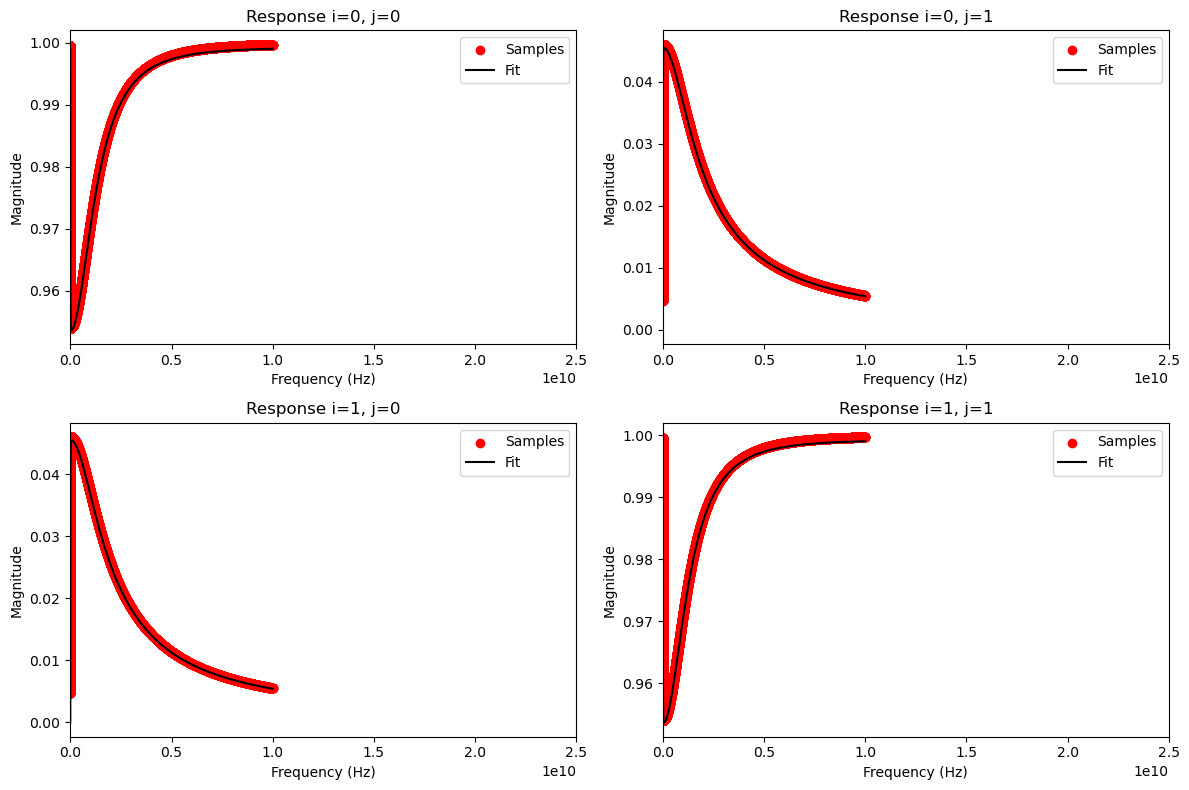

In [26]:
freqs1 = np.linspace(0, 10e9, 1001)
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 8)
vf.plot_s_mag(0, 0, freqs1, ax=ax[0][0]) # plot s11
ax[0][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 0, freqs1, ax=ax[1][0]) # plot s21
ax[1][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(0, 1, freqs1, ax=ax[0][1]) # plot s12
ax[0][1].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 1, freqs1, ax=ax[1][1]) # plot s22
ax[1][1].set_xlim([0.0, 0.25e11])
fig.tight_layout()
plt.show()

In [27]:
#vf.write_spice_subcircuit_s( 'E:\\Qucs_Projects\\Tests\\WCM_Circuit.cir' )
vf.write_spice_subcircuit_s( 'E:\\SPICE_Projects\\spicelib\\testfiles\\WCM_Circuit.cir' )

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\SPICE_Projects\\spicelib\\testfiles\\WCM_Circuit.cir'

In [ ]:
spice_time = time_ary-time_ary[0]
export_to_spice_pwl( spice_time, proton_sig_2, 'E:\\SPICE_Projects\\spicelib\\WCM_Test\\proton_sig_pwl.txt' )

__Direct Multiply with S21__

In [ ]:
wcm_ntw = wcm_ntwk.extrapolate_to_dc()
wcm_s21 = wcm_ntw.s[:,1,0]
Sig_s = fft(proton_sig_2)
Sig_s = 2*Sig_s[:proton_sig_2.size//2]

Tp = time_ary[1] - time_ary[0]
Fspec = fftfreq(proton_sig_2.size, Tp)
Fspec = Fspec[:proton_sig_2.size//2]
Fspec_step = Fspec[1] - Fspec[0]

In [ ]:
# --- Interpolation and Linearization
Fx = interp1d(Fspec, Sig_s)
Filt = interp1d(wcm_ntw.f, wcm_s21)
Freqx = np.arange(0.0, wcm_ntw.f[-1], Fspec_step)
NSig_s = Fx(Freqx)
Nlc_s21 = Filt(Freqx)

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


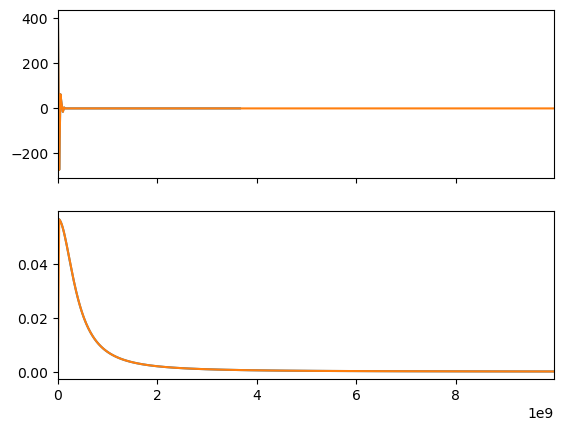

In [ ]:
# ---- Check Interpolation
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(Fspec[:150], np.real(Sig_s[:150]))
ax[0].plot(Freqx, np.real(NSig_s) )
ax[0].set_xlim([0.0, Freqx[-1]] )

ax[1].plot(wcm_ntw.f, wcm_s21)
ax[1].plot(Freqx, Nlc_s21)
ax[1].set_xlim([0.0, Freqx[-1]] )
plt.show()

In [ ]:
from scipy.fftpack import ifft


In [ ]:
Filt_Sig = NSig_s * Nlc_s21 
sig_filt = ifft( Filt_Sig )
#sig_filt *= (sig_filt.size/(Tp*2))
sig_ifft = ifft( Sig_s[:150] ) 

In [ ]:
time_ary.size

1000

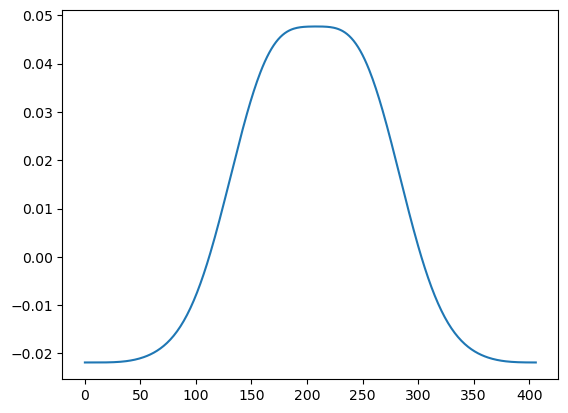

In [ ]:
plt.figure()
plt.plot(sig_filt)
#plt.plot(sig_ifft)
plt.show()

## SPICE Lab - WCM Tests
Using the spicelab library, see if I can run through simulations of the RHIC WCM over the new HSR waveforms

In [5]:
from spicelib import SimRunner, AscEditor, RawRead
from spicelib.log.ltsteps import LTSpiceLogReader
from spicelib.simulators.ltspice_simulator import LTspice
from pathlib import Path

In [6]:
# --- Get LTSpice File Path
path = input('file path: ')
name = input('file name (include extension): ')
asc_path = path + '\\' + name
# --- Create Output Folder
sim_output_path = path + '\\batch_output'
folder = Path(sim_output_path)
folder.mkdir(parents=True, exist_ok=True)

In [30]:
# select spice model
runner = SimRunner(simulator=LTspice, output_folder=sim_output_path)
wcm_asc = AscEditor(asc_path)

# set default arguments
wcm_asc.set_parameters(llf=189.79e-6, cbr=65.17e-12, ccc=15.7e-12, Ls=(2e-9/83), Cp=(0.5e-12)*83, rwcm=(100/83), rload=49.9 )
wcm_asc.add_instructions(
    "; Simulation settings",
    ";.param run = 0"
)
wcm_asc.set_parameter('run', 0)

In [8]:
# --- Make signals to test -- HSR Signals
num_bunches = 2
time_ary = np.linspace(-1*(num_bunches*0.5)/HSR_RF_24M, num_bunches*0.5/HSR_RF_24M, 3000)  # time array for 1 RF cycle

# --- Make HSR Signals
HSR_SIGS = {
    'INJ': cosine_square_pulse( time_ary, (1/HSR_RF_24M) ),
    'COOL': mod_cos_sq_pulse( time_ary, (1/HSR_RF_24M), HSR_RF_49M, 1.0, 0.25, 0.0 ),
    'RAMP': mod_cos_sq_pulse( time_ary, (1/HSR_RF_24M), HSR_RF_197M, 1.0, 0.33, 0.0 ),
    'STORE1': cosine_square_pulse( time_ary, (1/HSR_RF_197M) ),
    'STORE2': cosine_square_pulse( time_ary, (1/HSR_RF_591M) ),
}

In [9]:
spice_time = time_ary-time_ary[0]
Waveforms = {}
waveform_path = 'E:\\SPICE_Projects\\spicelib\\WCM_Test\\'

for waveform in HSR_SIGS.keys():              # --- Cycle through list of waveforms
    Waveforms[waveform] = waveform_path + 'Waveform_{}.txt'.format(waveform)
    export_to_spice_pwl( spice_time, HSR_SIGS[waveform], Waveforms[waveform] )

In [31]:
wcm_asc.remove_Xinstruction(r"\.TRAN.*")
wcm_asc.add_instructions(".TRAN 1p 100n 0 10p")

Instructions matching "\.TRAN.*" not found


In [32]:
alt_solver = True
for waveform in Waveforms.keys():              # --- Cycle through list of waveforms
    wcm_asc['I1']['Value'] = "PWL SCOPEDATA="+ Waveforms[waveform]  # --- Set V1 model to selected waveform
    print("simulating response to:", waveform)

    # small example on how to use options, here how to force the solver
    opts = []
    if alt_solver:
        opts.append('-alt')
    else:
        opts.append('-norm')

    runner.run(wcm_asc, switches=opts, exe_log=True)  # run, and log console output fo file

simulating response to: INJ
simulating response to: COOL
simulating response to: RAMP
simulating response to: STORE1
simulating response to: STORE2


In [34]:
data_test = {}
for raw, log in runner:
    print("Raw file: %s, Log file: %s" % (raw, log))
    # do something with the data
    raw_data = RawRead(raw)
    x = raw_data.get_wave('time')
    y1 = raw_data.get_wave('V(wcm_in)')
    y2 = raw_data.get_wave('V(wcm_out)')
    data_test[str(raw)[-1]] = (x, y1, y2)
    
    log_data = LTSpiceLogReader(log)
    # ...

# Sim Statistics
print('Successful/Total Simulations: ' + str(runner.okSim) + '/' + str(runner.runno))

Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_1.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_1.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_2.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_2.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_3.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_3.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_4.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_4.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_5.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_5.log
Successful/Total Simulations: 5/5


In [12]:
x = raw_data.get_wave('time')
y =raw_data.get_wave('V(wcm_out)')  

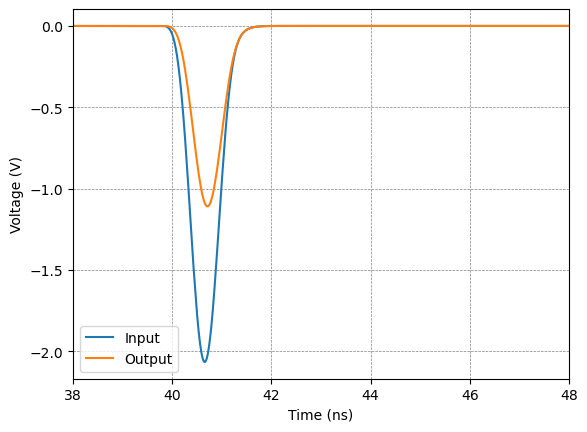

In [40]:
plt.Figure()
plt.plot(x*1e9,y1,x*1e9,y2)
plt.xlim([38, 48])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (V)')
plt.legend(['Input', 'Output'])
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.show()

In [29]:
enter = input("Press enter to delete created files")
if enter == '':
    runner.cleanup_files()

# HSR Profiles

In [105]:
# --- Make signals to test -- HSR Signals
num_bunches = 2
time_ary = np.linspace(-1*(num_bunches*0.5)/HSR_RF_24M, num_bunches*0.5/HSR_RF_24M, 3000)  # time array for 1 RF cycle

# --- Make HSR Signals
HSR_SIGS = {
    'PP_INJ'    : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_23GeV, pw_type="rms" ),
    'Au_INJ'    : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_10GeV, pw_type="rms" ),
    'PP_COOL'   : mod_cos_sq_pulse( time_ary, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_49M, pulsAmp=1.0, modAmp=1.0, phi=0.0 ),
    'PP_RAMP'   : mod_cos_sq_pulse( time_ary, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_197M, pulsAmp=1.0, modAmp=0.75, phi=0.0 ),
    'PP_41GEV'  : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_41GeV, pw_type="rms" ),
    'PP_100GEV' : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_100GeV, pw_type="rms" ),
    'PP_275GEV' : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_275GeV, pw_type="rms" ),
    'AU_41GEV'  : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_41GeV, pw_type="rms" ),
    'AU_110GEV' : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_110GeV, pw_type="rms" ),
}

In [106]:
Fs = 1/(time_ary[1] - time_ary[0])

# --- Make HSR Spectra
HSR_SPECS = {
    'PP_INJ'    : get_spectrum( HSR_SIGS['PP_INJ'],     Fs )[1],
    'Au_INJ'    : get_spectrum( HSR_SIGS['Au_INJ'],     Fs )[1],
    'PP_COOL'   : get_spectrum( HSR_SIGS['PP_COOL'],    Fs )[1],
    'PP_RAMP'   : get_spectrum( HSR_SIGS['PP_RAMP'],    Fs )[1],
    'PP_41GEV'  : get_spectrum( HSR_SIGS['PP_41GEV'],   Fs )[1],
    'PP_100GEV' : get_spectrum( HSR_SIGS['PP_100GEV'],  Fs )[1],
    'PP_275GEV' : get_spectrum( HSR_SIGS['PP_275GEV'],  Fs )[1],
    'AU_41GEV'  : get_spectrum( HSR_SIGS['AU_41GEV'],   Fs )[1],
    'AU_110GEV' : get_spectrum( HSR_SIGS['AU_110GEV'],  Fs )[1],
}
freq_ary, __ = get_spectrum( HSR_SIGS['PP_INJ'], Fs )

### Injection

In [45]:
injection_sig = { 'PP_INJ':HSR_SIGS['PP_INJ'], 'Au_INJ':HSR_SIGS['Au_INJ'] }
injection_spec = { 'PP_INJ':HSR_SPECS['PP_INJ'], 'Au_INJ':HSR_SPECS['Au_INJ'] }

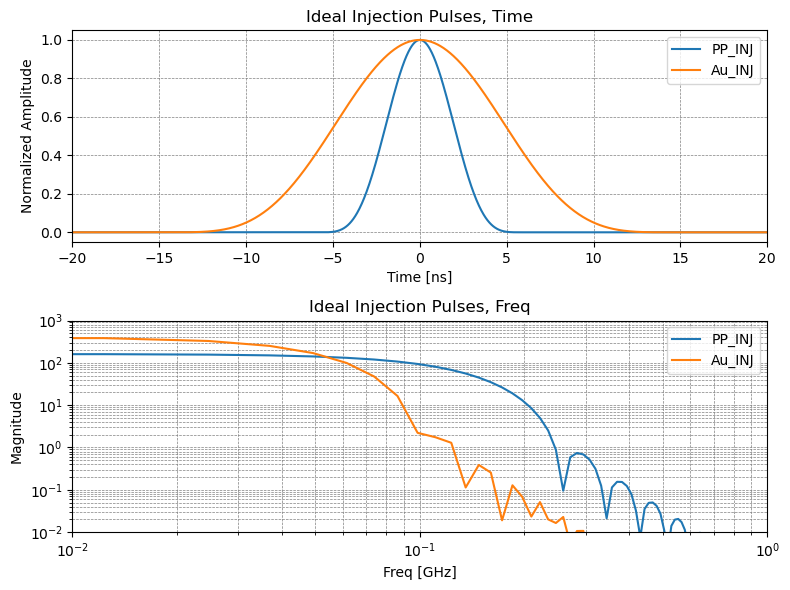

In [82]:
plot_gaus_pulses( time_ary, injection_sig, freq_ary, injection_spec,
                 ax1_xlim=[-20, 20], title="Ideal Injection Pulses",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

### Injection Cooling

C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


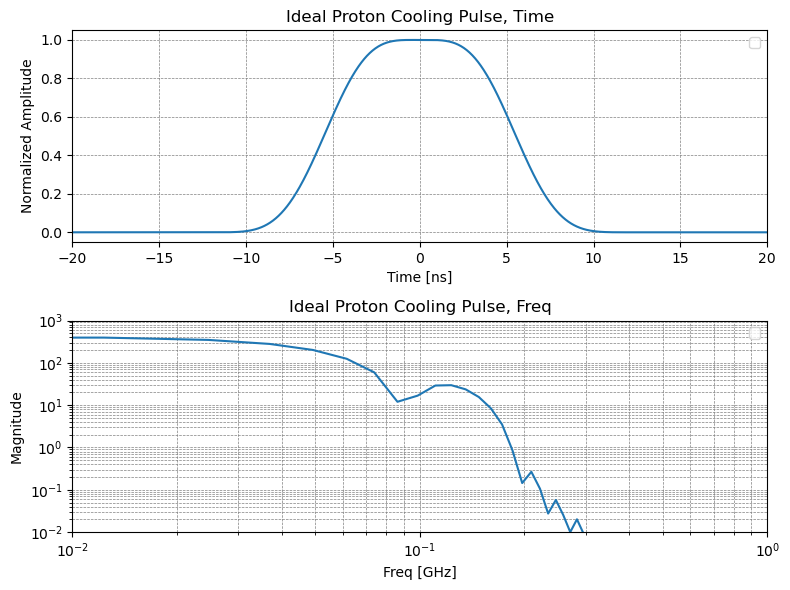

In [83]:
plot_gaus_pulses( time_ary, HSR_SIGS['PP_COOL'], freq_ary, HSR_SPECS['PP_COOL'],
                 ax1_xlim=[-20, 20], title="Ideal Proton Cooling Pulse",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

### Acceleration Ramp
- 197 Modulation 
- Splitting

C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


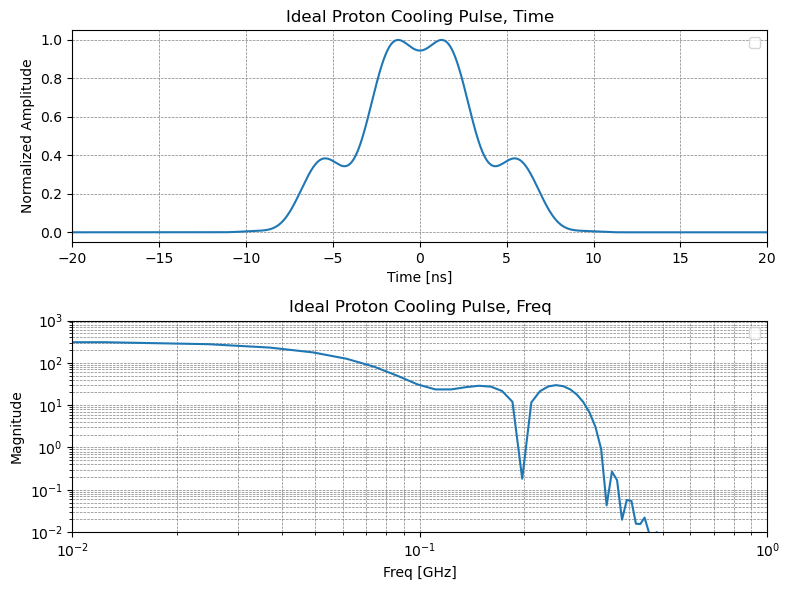

In [ ]:
plot_gaus_pulses( time_ary, HSR_SIGS['PP_RAMP'], freq_ary, HSR_SPECS['PP_RAMP'],
                 ax1_xlim=[-20, 20], title="Ramp Stability Pulse",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

### Store

In [97]:
store_sig = {'PP_41GEV':HSR_SIGS['PP_41GEV'],'PP_100GEV':HSR_SIGS['PP_100GEV'],'PP_275GEV':HSR_SIGS['PP_275GEV'],'AU_41GEV':HSR_SIGS['AU_41GEV'], 'AU_110GEV':HSR_SIGS['AU_110GEV'],}
store_spec = {'PP_41GEV':HSR_SPECS['PP_41GEV'],'PP_100GEV':HSR_SPECS['PP_100GEV'],'PP_275GEV':HSR_SPECS['PP_275GEV'],'AU_41GEV':HSR_SPECS['AU_41GEV'], 'AU_110GEV':HSR_SPECS['AU_110GEV'],}

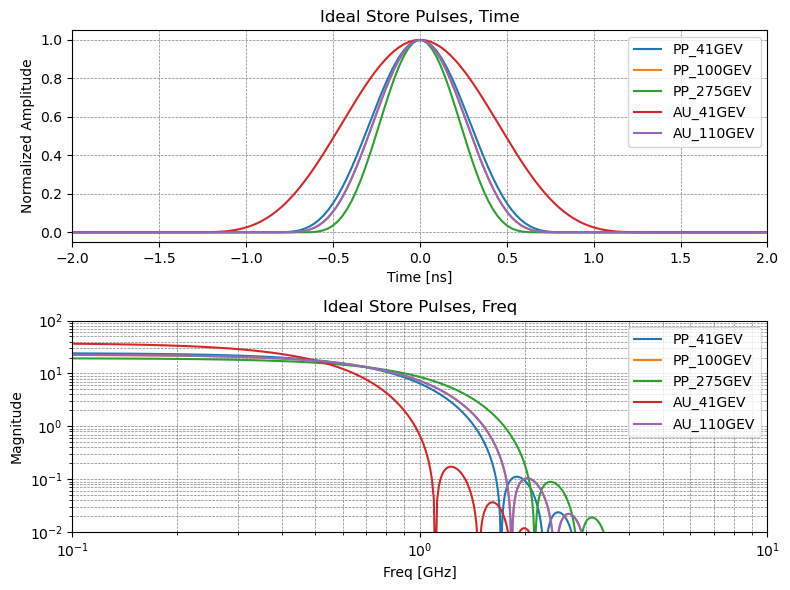

In [100]:
plot_gaus_pulses( time_ary, store_sig, freq_ary, store_spec,
                 ax1_xlim=[-2, 2], title="Ideal Store Pulses",
                 ax2_xlim=[0.1, 10], ax2_ylim=[1e-2, 100], loglog=True,
                 )

# ESR Profiles

In [2]:
# --- Make signals to test -- ESR Signals
num_bunches = 2
etime_ary = np.linspace(-1*(num_bunches*0.5)/ESR_RF_591M, num_bunches*0.5/ESR_RF_591M, 3000)  # time array for 1 RF cycle

# --- Make ESR Signals
ESR_SIGS = {
    'STORE_5GeV': gaussian_pulse( etime_ary, ESR_BUNCH_LENGTH_5GeV ),
    'STORE_18GeV': gaussian_pulse( etime_ary, ESR_BUNCH_LENGTH_18GeV ),
}

In [3]:
eFs = 1/(etime_ary[1] - etime_ary[0])

# --- Electron Spectrum
ePS_freq, ePS_spec5GeV = get_spectrum( ESR_SIGS['STORE_5GeV'][0], eFs )
__, ePS_spec18GeV = get_spectrum( ESR_SIGS['STORE_18GeV'][0], eFs )

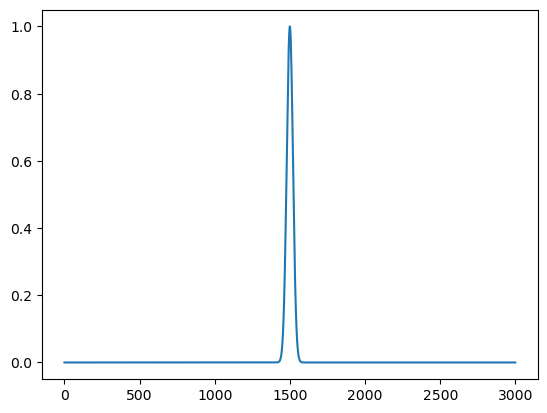

In [4]:
plt.figure()
plt.plot(ESR_SIGS['STORE_5GeV'][0])
plt.show()

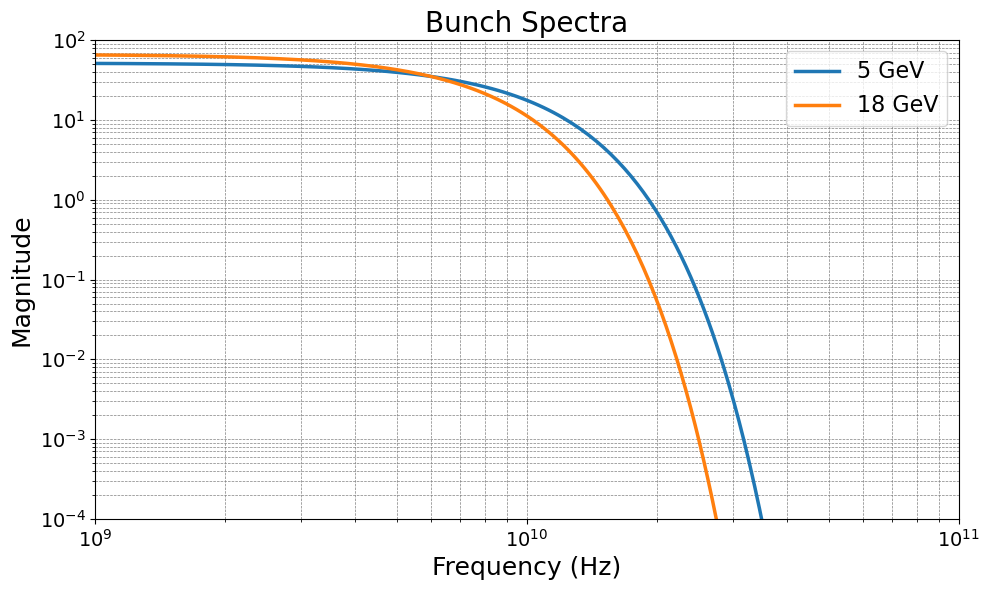

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ePS_freq[ePS_freq>0], np.abs(ePS_spec5GeV[ePS_freq>0]), label='5 GeV',linewidth=2.5)
ax.plot(ePS_freq[ePS_freq>0], np.abs(ePS_spec18GeV[ePS_freq>0]), label='18 GeV',linewidth=2.5)
# ax.plot(et_freq[et_freq>0], np.abs(et_spec[et_freq>0]), label='Electrons',linewidth=2.5)
# --- 
ax.set_xlim(1e9, 1e11)
ax.set_ylim(1e-4, 1e2)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
a = np.abs(ePS_spec5GeV[ePS_freq>0][np.argmax( np.abs(ePS_spec5GeV[ePS_freq>0]) )])
b = np.abs(ePS_spec5GeV[ePS_freq>0][60] )
print( a )
print( b )
print( 20*np.log10(b/a) )


51.84884085328877
1.572991216294729
-30.36025508265551


In [25]:
(0.5/ESR_BUNCH_LENGTH_5GeV)*1e-9

21.41327623126339

# test

In [41]:
calc_ind_cocentric_cylinders( 6500, 0.161925, 0.073787, 0.2286 )

0.00023356882937324524

In [42]:
calc_cap_cocentric_cylinders( 10, 0.161925, 0.073787 )

7.0783705288347e-10

In [43]:
rpc_resistor = import_spram()

FileNotFoundError: [Errno 2] No such file or directory: '\\'

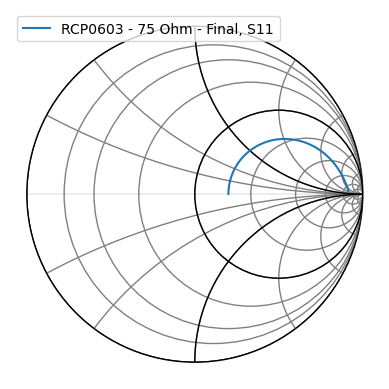

In [ ]:
rpc_resistor.plot_s_smith()

In [ ]:
# Convert to Z-parameters (input impedance)
z = rpc_resistor.z[:, 0, 0]  # Get Z11 over all frequencies
f = rpc_resistor.f  # Frequency array in Hz

# Calculate series inductance from imaginary part of Z
X = np.imag(z)
L_series = X / (2 * np.pi * f)

# Convert Z to admittance (for parallel capacitance extraction)
y = 1 / z
B = np.imag(y)
C_parallel = -B / (2 * np.pi * f)

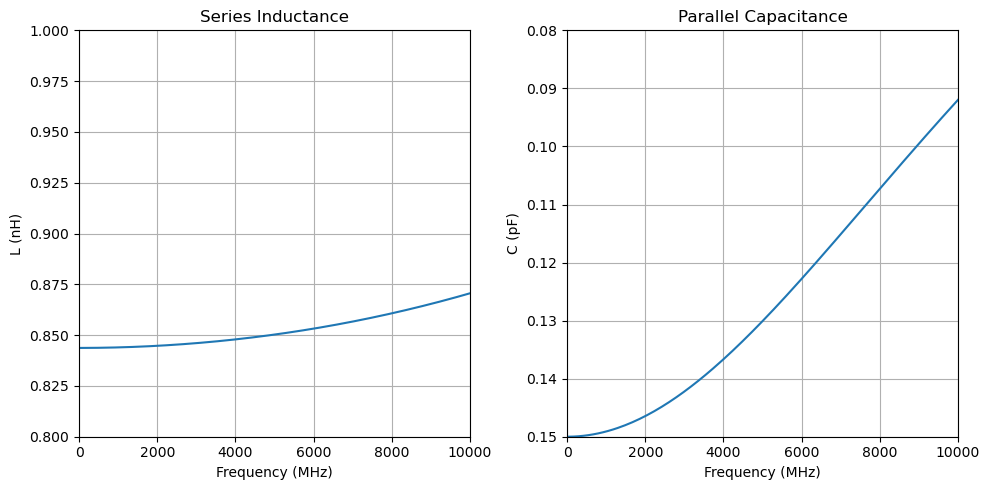

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(f / 1e6, L_series * 1e9)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.8, 1.0])
plt.title("Series Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")

plt.subplot(1, 2, 2)
plt.plot(f / 1e6, C_parallel * 1e12)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.15, 0.08])
plt.title("Parallel Capacitance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("C (pF)")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'L (nH)')

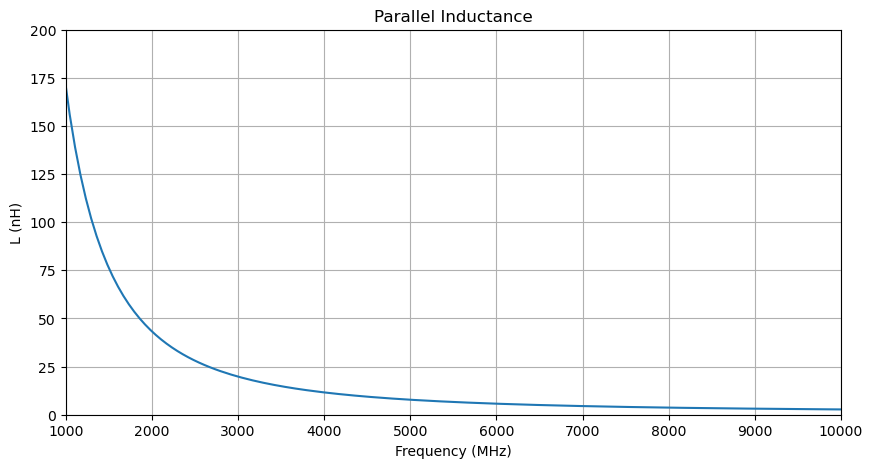

In [ ]:
L_parallel = -1 / (2 * np.pi * f * B)

plt.figure(figsize=(10, 5))
plt.plot(f / 1e6, L_parallel * 1e9)
plt.grid(True,which='both')
plt.xlim([1000, 10000])
plt.ylim([0.00, 200])
plt.title("Parallel Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")


In [87]:
const.epsilon_0

8.8541878128e-12

In [1]:
def inches_to_centimeters(inches):
    """
    Convert inches to centimeters.

    Args:
        inches (float): The value in inches.

    Returns:
        float: The value in centimeters.
    """
    return inches * 2.54

In [4]:
print("8.9950 in = {} cm".format( inches_to_centimeters(8.9950) ) )
print("2.1125 in = {} cm".format( inches_to_centimeters(2.1125) ) )
print("1.3825 in = {} cm".format( inches_to_centimeters(1.3825) ) )
print("1.0000 in = {} cm".format( inches_to_centimeters(1.0000) ) )
print("5.0000 in = {} cm".format( inches_to_centimeters(5.0000) ) )
print("3.5000 in = {} cm".format( inches_to_centimeters(3.5000) ) )
print("5.5000 in = {} cm".format( inches_to_centimeters(5.5000) ) )
print("2.8750 in = {} cm".format( inches_to_centimeters(2.8750) ) )
print("0.0770 in = {} cm".format( inches_to_centimeters(0.0770) ) )
print("0.1250 in = {} cm".format( inches_to_centimeters(0.1250) ) )
print("7.0800 in = {} cm".format( inches_to_centimeters(7.0800) ) )

8.9950 in = 22.847299999999997 cm
2.1125 in = 5.365749999999999 cm
1.3825 in = 3.51155 cm
1.0000 in = 2.54 cm
5.0000 in = 12.7 cm
3.5000 in = 8.89 cm
5.5000 in = 13.97 cm
2.8750 in = 7.3025 cm
0.0770 in = 0.19558 cm
0.1250 in = 0.3175 cm
7.0800 in = 17.9832 cm


In [2]:
calc_cap_cocentric_cylinders( 1.0, 0.14986, 0.073025, 0.203073 )

1.5714931585376497e-11

In [10]:
convert_lengths( [7.995,5.900,2.875],["in"]*3,"m", show=True )

7.995 in = 0.2031 m
5.9 in = 0.1499 m
2.875 in = 0.0730 m


[0.203073, 0.14986, 0.07302499999999999]

In [5]:
calc_ind_cocentric_cylinders( 6500, 0.14986, 0.073025, 0.203073 )

0.00018978584835382684

In [4]:
c1 = calc_cap_parallel_plate( 9.5, 0.00246, 0.003175)
c2 = calc_cap_parallel_plate( 9.5, 0.00246, 0.0039116)
print( "Correct gap = {} pF".format(c1*1e12) )
print( "Modeled gap = {} pF".format(c2*1e12) )
print( "Difference = {} pF".format((c1-c2)*1e12) )

Correct gap = 65.17239974334993 pF
Modeled gap = 52.89967511635546 pF
Difference = 12.272724626994473 pF


In [42]:

def cosine_squared_pulse(t: np.ndarray, pulse_width: float) -> np.ndarray:
    """
    Generate a cosine-squared pulse.

    Args:
        t (np.ndarray): Time array.
        pulse_width (float): Half-width of the pulse (T), i.e., duration from 0 to peak.

    Returns:
        np.ndarray: Pulse waveform.
    """
    pulse = np.zeros_like(t)
    mask = np.abs(t) <= pulse_width/2
    pulse[mask] = np.cos(np.pi * t[mask] / ( pulse_width)+(15*np.pi/180))**2
    return pulse


In [14]:
def mod_cos_sq_pulse(t: np.ndarray, pulse_width: float, baseF: float, modF: float, pw_type: str = 'fixed', pulsAmp: float = 1.0, modAmp: float = 1.0, phi: float = 0.0) -> np.ndarray:
    """Modulate a cosine square pulse with multiple frequencies.
    
    Args:
        t (np.ndarray): Time array.
        pulse_width (float): Pulse width in seconds. Width is configurable by optional argument `pw_type`.
        baseF (float): Base frequency of the cosine square pulse.
        modF (float): Modulation frequency.
        pw_type (str, optional): Pulse width type. Defaults to 'fixed'.
        pulsAmp (float, optional): Amplitude of the cosine square pulse. Defaults to 1.0.
        modAmp (float, optional): Amplitude of the modulation frequencies. Defaults to 1.0.
        phi (float, optional): Signal phase in degrees. Defaults to 0.
    
    Returns:
        np.ndarray: Modulated cosine square waveform.
    """
    csp = cosine_square_pulse(t, pulse_width, pw_type=pw_type, amplitude=pulsAmp, phi=phi)
    csp_sin = np.sin((baseF)*2*np.pi*t)
    
    mod_sin = modAmp*np.sin((modF)*2*np.pi*t)

    mod_csp = (csp_sin*mod_sin+np.sqrt(modAmp**2+pulsAmp**2))
    mod_csp *= csp
    mod_csp /= mod_csp.max()

    return mod_csp

pulse width = 0.15552235832619166 ns


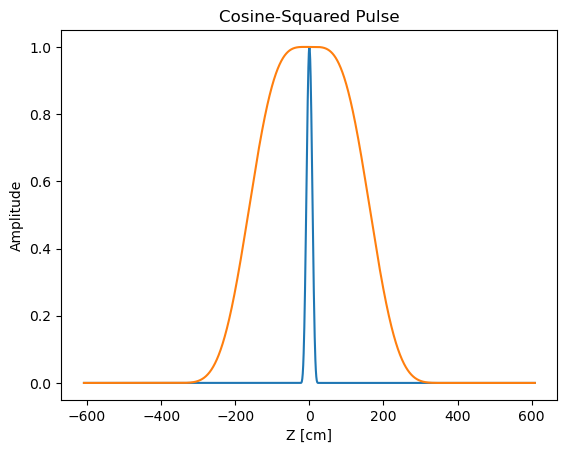

In [74]:
# Time base
t = np.linspace(-0.5/HSR_RF_24M, 0.5/HSR_RF_24M, 2000)

# Generate a cosine-square pulse with 1 µs width
pulse1 = cosine_square_pulse(t, HSR_PP_BUNCH_LENGTH_100GeV, pw_type="rms")
pulse2 = mod_cos_sq_pulse(t, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_49M, modAmp=1 )
print( "pulse width = {} ns".format(calculate_pulse_width(pulse2, (t[1]-t[0]))) )
# Plot

plt.figure()
plt.plot(t * const.c*100, pulse1, t*const.c*100, pulse2 )
# plt.plot(t * 1e6, pulse2 )
plt.title("Cosine-Squared Pulse")
plt.xlabel("Z [cm]")
plt.ylabel("Amplitude")
# plt.xlim([-30, 30])
plt.show()


In [4]:
peaks, s = sg.find_peaks(pulse2)
peak_val, left, right = sg.peak_prominences(pulse2, peaks)
print( t[left] )
print( t[right] )
print( "Absolute width = {} ns".format( abs(t[right] - t[left]) * 1e9 ) )
# sg.peak_widths(pulse2, peaks)


[-5.83900951e-09]
[5.83900951e-09]
Absolute width = [11.67801903] ns


In [92]:
print("24MHz cavity period = {} ns".format((1/HSR_RF_24M)*1e9))
print("PP Store 41GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_41GeV)*7.0e9))
print("PP Store 100GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_100GeV)*7.0e9))
print("PP Store 275GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_275GeV)*7.0e9))
print("Au Store 41GeV = {} ns".format((HSR_AU_BUNCH_LENGTH_41GeV)*7.0e9))
print("Au Store 110GeV = {} ns".format((HSR_AU_BUNCH_LENGTH_110GeV)*7.0e9))

24MHz cavity period = 40.59888701155576 ns
PP Store 41GeV = 1.7512114997902983 ns
PP Store 100GeV = 1.6344640664709453 ns
PP Store 275GeV = 1.4009691998322384 ns
Au Store 41GeV = 2.708540453008995 ns
Au Store 110GeV = 1.6344640664709453 ns


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict, Tuple

def plot_gaus_pulses(
    t: np.ndarray,
    pulses: Union[Dict[str, np.ndarray], np.ndarray],
    freq: np.ndarray,
    pulse_spec: Union[Dict[str, np.ndarray], np.ndarray],
    title: str = None,
    ax1_xlabel: str = None,
    ax1_ylabel: str = None,
    ax1_xlim: Tuple[float, float] = None,
    ax1_ylim: Tuple[float, float] = None,
    ax2_xlabel: str = None,
    ax2_ylabel: str = None,
    ax2_xlim: Tuple[float, float] = None,
    ax2_ylim: Tuple[float, float] = None,
    grid: bool = True,
    legend: bool = True,
    loglog: bool = False,
    figsize: Tuple[int, int] = (8, 6),
    dpi: int = 100,
    **kwargs
) -> None:
    """
    Plot Gaussian pulses in time and frequency domains.

    Parameters:
    t (np.ndarray): Time array
    pulses (Union[Dict[str, np.ndarray], np.ndarray]): Dictionary of pulse values or single pulse array
    freq (np.ndarray): Frequency array
    pulse_spec (Union[Dict[str, np.ndarray], np.ndarray]): Dictionary of pulse spectra or single pulse spectrum array
    title (str, optional): Plot title. Defaults to None.
    ax1_xlabel (str, optional): X-axis label for time plot. Defaults to None.
    ax1_ylabel (str, optional): Y-axis label for time plot. Defaults to None.
    ax1_xlim (Tuple[float, float], optional): X-axis limits for time plot. Defaults to None.
    ax1_ylim (Tuple[float, float], optional): Y-axis limits for time plot. Defaults to None.
    ax2_xlabel (str, optional): X-axis label for frequency plot. Defaults to None.
    ax2_ylabel (str, optional): Y-axis label for frequency plot. Defaults to None.
    ax2_xlim (Tuple[float, float], optional): X-axis limits for frequency plot. Defaults to None.
    ax2_ylim (Tuple[float, float], optional): Y-axis limits for frequency plot. Defaults to None.
    grid (bool, optional): Show grid. Defaults to True.
    legend (bool, optional): Show legend. Defaults to True.
    loglog (bool, optional): Use log-log scale for frequency plot. Defaults to False.
    figsize (Tuple[int, int], optional): Figure size. Defaults to (8, 6).
    dpi (int, optional): Figure DPI. Defaults to 100.
    **kwargs: Additional keyword arguments for plot customization

    Returns:
    None
    """
    tt = t*1e9  # Convert time to nanoseconds
    ff = freq*1e-9  # Convert frequency to GHz

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, dpi=dpi)

    if isinstance(pulses, dict):
        for p in pulses.keys():
            # sigma = calculate_pulse_width(pulses[p], t[1] - t[0]) / 1e9
            # ax1.plot(tt, pulses[p], label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
            ax1.plot(tt, pulses[p], label=p)
            if loglog:
                ax2.loglog(ff, np.abs(pulse_spec[p]), label=p)
                        #    label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
                            
            else:
                ax2.plot(ff, np.abs(pulse_spec[p]),label=p)
                        #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
    else:
        # sigma = calculate_pulse_width(pulses, t[1] - t[0]) / 1e9
        ax1.plot(tt, pulses, )
                #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
        if loglog:
            ax2.loglog(ff, np.abs(pulse_spec), )
                    #    label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
        else:
            ax2.plot(ff, np.abs(pulse_spec), )
                    #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
            
    ax1.grid(axis="both", which="both" if grid else "none", ls='--', lw=0.5, color='gray')
    ax1.set_xlabel(ax1_xlabel or "Time [ns]")
    ax1.set_ylabel(ax1_ylabel or "Normalized Amplitude")
    ax1.set_title(title+", Time" or 'Ideal Beam Pulse, Time')
    if ax1_xlim:
        ax1.set_xlim(ax1_xlim)
    if ax1_ylim:
        ax1.set_ylim(ax1_ylim)
    if legend:
        ax1.legend()

    ax2.grid(axis="both", which="both" if grid else "none", ls='--', lw=0.5, color='gray')
    ax2.set_xlabel(ax2_xlabel or "Freq [GHz]")
    ax2.set_ylabel(ax2_ylabel or "Magnitude")
    ax2.set_title(title+", Freq" or 'Ideal Beam Pulse, Freq.')
    if ax2_xlim:
        ax2.set_xlim(ax2_xlim)
    if ax2_ylim:
        ax2.set_ylim(ax2_ylim)
    if legend:
        ax2.legend()

    plt.tight_layout()
    plt.show()